<a href="https://colab.research.google.com/github/Lenadeu/Time-series-anomaly-detection/blob/main/SARIMAX_forecating_period_from_autocorrelation4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install psutil
#pip install numpy
#pip install matplotlib
#pip install scikit-learn
#pip install kmeanstf
#pip install tensorflow-gpu
#!pip install tslearn
#!pip install netdata_pandas
#!pip install am4894plots
#!pip install minisom
#!pip install tslearn
#!pip install quantecon
#!pip install nitime

#!pip install statsmodels.tsa.seasonal

#!pip install statsmodels
#!pip install stldecompose

#!pip install statsmodels==0.12.1

#pip install statsmodels==0.12.1
!pip install statsmodels==0.10.2

#!pip install sesd
#!pip install plotly

!pip install pmdarima

!pip install chart-studio


     |████████████████████████████████| 8.1 MB 4.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.1
    Uninstalling statsmodels-0.13.1:
      Successfully uninstalled statsmodels-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pmdarima 1.8.4 requires statsmodels!=0.12.0,>=0.11, but you have statsmodels 0.10.2 which is incompatible.
  Using cached statsmodels-0.13.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#import plotly.plotly as py

import matplotlib.pyplot as plt
from matplotlib import pyplot

import plotly.graph_objs as go
init_notebook_mode(connected=True)

import math

##import statsmodels.api as sm
##import statsmodels.tsa.api as smt


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

import statistics

from sklearn.metrics import mean_squared_error

from matplotlib import pyplot
import matplotlib.pyplot as plt
#import plotly.plotly as py
import plotly.tools as tls

import seaborn as sns

# Basic imports
from math import sqrt

# Machine learning basics
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model


# Basic imports
import datetime # manipulating date formats
import itertools
import time
import holidays
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE

# Stats packages
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# AUTOARIMA 
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

import chart_studio.plotly as py
import plotly.graph_objs as go

In [ ]:
#splitting indexes between train and test data from files  
def get_splitting_ind_from_file(filename):
    
   
    split_ind = -1000000000
     
    #get extention 
    ext = os.path.splitext(filename)[-1].lower()
    
    print('ext=',ext)

    #if extention is not "txt" then return nothing
    if ext != ".txt":
        return '',''
    
    #get index of splitting from train to test from file name 
    split_ind_t = os.path.basename(filename).split('_')[3]
    split_ind=(int(split_ind_t[:-4]))
    
    
    
    return split_ind

In [ ]:
#get train and test data for all series 
def get_train_test_data(time_series_df,split_ind):
    
    
    print('time series: ',time_series_df.head())

    print('split index',split_ind)

    train_df=time_series_df.iloc[0:split_ind,0]

    test_df=time_series_df.iloc[split_ind:-1,0]

    return test_df,train_df

In [ ]:
def is_accurate(pred: int, start: int, end: int) -> bool:
    """Compute whether a prediction is accurate enough

    Args:
        pred (int): predicted time series step of the center of the anomaly
        start (int): true start of anomaly
        end (int): true end of anomaly

    Returns:
        bool: prediction is accurate
    """
    accepted_inaccuracy = 100  # slack for short anomalies
    length_anomaly = end - start + 1
    if (
        min(start - length_anomaly, start - accepted_inaccuracy)
        < pred
        < max(end + length_anomaly, end + accepted_inaccuracy)
    ):
        return True
    else:
        return False

In [ ]:
# Draw Plot for pandas data frame using pyplot 
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [ ]:
def period_estimation(time_series_df):
   
    autocor = []
    bunches = []
    this_bunch = []
    for i_lag in range(len(time_series_df.values)):
        if i_lag > 0.25: 
            ac = time_series_df['Data'].autocorr(lag=i_lag)
            autocor.append(ac)
            if ac < 0.25:
                if this_bunch:
                    bunches.append(this_bunch.copy())
                    this_bunch = []
            else:
                this_bunch.append(ac)

    fig1, ax1 = plt.subplots()  
  
    ax1.plot(bunches[1])
    ax1.plot(bunches[2])
    plt.show()

    P = autocor.index(max(bunches[2])) - autocor.index(max(bunches[1]))
    ax1.plot(autocor)
    plt.show()
    print('Period autocorrelation',P)

    return P





In [ ]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=7*4, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))



In [ ]:
# Define function
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency (=period!!!) : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                print('comb and combs',comb,combs)
                mod = sm.tsa.statespace.SARIMAX(ts, 
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                print('ans', ans)
                print('SARIMAX {} x {}12 : BIC Calculated ={} \n'.format(comb, combs, output.bic))
            except:
                continue
    
    print('ans',ans)        
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]

    print('top 5 models',ans_df)
    
    return ans_df['pdq'][0],ans_df.iloc['pdqs'][0]

In [ ]:
def find_max_difference_with_loc(Time_Series, WinSize):
   
    n=len(Time_Series)
    
    k=WinSize 
    
    Max_Win_val = -1
    Max_Win_loc = -1 
    
    #for the whole series minus last window  
    for i in range(n - k + 1):
        #i - begining of a window     
        Windows_mean=statistics.mean(Time_Series[i:i+k-1])
        #Windows_ind[i]=i
        
        if Windows_mean > Max_Win_val:
            Max_Win_val = Windows_mean
            Max_Win_loc = i
    
    
    return Max_Win_val,Max_Win_loc 
    

In [ ]:
def find_window_with_max_anomalies(Test_Data, Anomalies_Inds, Win_Size, Split_Ind):

    # skip skip_n first windows 
    skip_n = 5
   
    #number of points in test data 
    N = len(Test_Data)

    #number of anomoluos points 
    AN = len(Anomalies_Inds)

    
    #window size 
    WS=Win_Size 

    #number of windows in test data 
    Num_of_Wins=int(N/WS)
    
    Max_Win_val = -1
    Max_Win_loc = -1 

    #number of anomalies in all windows, initialized with 0's 
    Num_of_Anomalies_In_Win = [0] * Num_of_Wins
    
    # index of window 
    k = 0
    # start skip_n window    
    Cur_Pos = Split_Ind 


    Cur_Pos_Win = [Cur_Pos]

    #for all windows withing test set lenght  
    while Cur_Pos < Split_Ind + N:

        # check all anomalies if they are located in window Cur_Pos : Cur_Pos + WS 
        for i in range(AN):

            if (Anomalies_Inds[i] > Cur_Pos and Anomalies_Inds[i] < Cur_Pos + WS):
              #anomaly i belongs to window Cur_Pos - Cur_Pos + WS
              Num_of_Anomalies_In_Win[k]=Num_of_Anomalies_In_Win[k]+1 

        #Next window 
        
        Cur_Pos = Cur_Pos + WS  
        
        #location of k-th window 
        Cur_Pos_Win.append(Cur_Pos)

        #Next window index 
        k = k + 1
        

    Max_Anomalies=-1
    Max_Win_ind=-1
    Max_Win_loc=-1 

    for i in range(len(Num_of_Anomalies_In_Win)):

        if(Num_of_Anomalies_In_Win[i] > Max_Anomalies): 
  
            Max_Anomalies = Num_of_Anomalies_In_Win[i]
            Max_Win_ind = i 
            Max_Win_loc = Cur_Pos_Win[i]


    print('Max_Anomalies', Max_Anomalies)
    print('Max_Win_ind', Max_Win_ind)
    print('Max_Win_loc', Max_Win_loc)

  

    return Max_Anomalies, Max_Win_loc

In [ ]:
def plotSARIMAX_m(train_data, test_data, pred_model,res,seasonal):
    fig = plt.figure(figsize=(12, 8))
    layout = (2, 2)
    ax1 = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax3 = plt.subplot2grid(layout, (1, 0))
    ax4 = plt.subplot2grid(layout, (1, 1))
    train_data.plot(ax=ax1);
    t = 'MSE: {}'.format(mean_squared_error(test_data,pred_model.predicted_mean))
    pred_model.predicted_mean.plot(ax=ax1, title=t, label = 'Prediction')
    test_data.plot(ax=ax1, label = 'Reality')
    ax1.fill_between(pred_model.conf_int(alpha = 0.1).index, 
                     pred_model.conf_int(alpha = 0.1).iloc[:,0], 
                     pred_model.conf_int(alpha = 0.1).iloc[:,1], 
                     alpha=0.5,facecolor='grey')
    ax3 = sm.graphics.tsa.plot_acf(res.resid, lags=seasonal, alpha=.05, ax=ax3, title="ACF of residuals")
    ax4 = sm.graphics.tsa.plot_pacf(res.resid, lags=seasonal, alpha=.05, ax=ax4, title="PACF of residuals")
    plt.tight_layout()
    ax1.legend()
    print("ACF and PACF of residuals")
    


In [ ]:
def detect_classify_anomalies(predicted_df,window,split_ind):

    predicted_df.replace([np.inf, -np.inf], np.NaN, inplace=True)
    predicted_df.fillna(0,inplace=True)

    # error=actual data - predicted mean  
    predicted_df['error']=predicted_df['actuals']-predicted_df['predicted mean']
    # error in percents 
    predicted_df['percentage_change'] = ((predicted_df['actuals'] - predicted_df['predicted mean']) / predicted_df['actuals']) * 100
    # rolling mean 
    predicted_df['meanval'] = predicted_df['error'].rolling(window=window).mean()
    # rolling std 
    predicted_df['deviation'] = predicted_df['error'].rolling(window=window).std()

    # rolling mean - 3*std 
    predicted_df['-3s'] = predicted_df['meanval'] - (2 * predicted_df['deviation'])
    # rolling mean + 3*std 
    predicted_df['3s'] = predicted_df['meanval'] + (2 * predicted_df['deviation'])
    
    predicted_df['-2s'] = predicted_df['meanval'] - (1.5 * predicted_df['deviation'])
    predicted_df['2s'] = predicted_df['meanval'] + (1.5 * predicted_df['deviation'])
    predicted_df['-1s'] = predicted_df['meanval'] - (1 * predicted_df['deviation'])
    predicted_df['1s'] = predicted_df['meanval'] + (1 * predicted_df['deviation'])
    
    #cut_list = df[['error', '-3s', '-2s', '-1s', 'meanval', '1s', '2s', '3s']]
    #cut_values = cut_list.values
    #print('cut_values',cut_values)
    #cut_sort = np.sort(cut_values)
    #print('cut_sort',cut_sort)
    
    #df['impact'] = [(lambda x: np.where(cut_sort == df['error'][x])[1][0])(x) for x in range(len(df['error']))]
    
    #severity = {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3}

    #region = {0: "NEGATIVE", 1: "NEGATIVE", 2: "NEGATIVE", 3: "NEGATIVE", 4: "POSITIVE", 5: "POSITIVE", 6: "POSITIVE",
    #          7: "POSITIVE"}

    #df['color'] =  df['impact'].map(severity)
    #df['region'] = df['impact'].map(region)
    
    #df['anomaly_points'] = np.where(df['color'] == 3, df['error'], np.nan)

    #print(df['anomaly_points'])

    #df = df.sort_values(by='load_date', ascending=False)
    #df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y-%m-%d")

    anomaly=[]
    anomaly_ind=[]


    for i in range(len(predicted_df)):
      
      
      if (predicted_df['error'].values[i] > predicted_df['3s'].values[i] or predicted_df['error'].values[i] < predicted_df['-3s'].values[i]):

          print('ind=',i+split_ind)
          print("predicted_df['actuals'].values[i]",predicted_df['actuals'].values[i])
          print("predicted_df['3s'].values[i]",predicted_df['3s'].values[i])
          print("predicted_df['-3s'].values[i]",predicted_df['-3s'].values[i])   
          anomaly.append(predicted_df['actuals'].values[i])
          anomaly_ind.append(i+split_ind)
  

    return anomaly, anomaly_ind

In [ ]:
def evaluation_time_series(series_filename,real_anomaly_start,real_anomaly_end):
    
    #for plotting with seaborn ############
    sns.set()
    #######################################
    
    #window for searching anomaly 
    #Anomaly_search_Window = 100
    
    #file with data  
    #print("file name = ",series_filename)
    path="drive/MyDrive/Colab Notebooks/AILab/Data/"
    
    # get time series from the file
    time_series_df = pd.read_csv(path+os.path.join(series_filename),names=['Data'])
    

    print('time seried data frame',time_series_df.head())

    print('time seried data frame',time_series_df)

    print('time_series_df shape = ',time_series_df.shape)


    fig, ax = plt.subplots()
    ax.plot(time_series_df.values)
    plt.title('initial series')

    ############### normalization - to the range 0 - 1 

    time_series_df = (time_series_df - time_series_df.min()) / (time_series_df.max() - time_series_df.min())

    ############## standartization - standart normal distribution, mean =0, std =1 

    
    time_series_df = (time_series_df - time_series_df.mean()) / time_series_df.std()


    ############           get period with autocorrelation

     
    P = period_estimation(time_series_df)

    
    #period 
    window_size=P


    ######################### test-train split 

    #
    split_ind=get_splitting_ind_from_file(series_filename)
    print('split index',split_ind)

    

    # get train-test data 
    test_df,train_df = get_train_test_data(time_series_df,split_ind)


    
    print('train time seried data frame',train_df.head())

    print('train time seried data frame',train_df)

    print('train time_series_df shape = ',train_df.shape)

    
    print('test time seried data frame',test_df.head())

    print('test time seried data frame',test_df)

    print('test time_series_df shape = ',test_df.shape)

    # decomposition
    #

    # decomposition 1 
    #from stldecompose import decompose, forecast
    #from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)

    # Multiplicative Decomposition 
    #result_mul = seasonal_decompose(time_series_df, model='multiplicative',period=P)

    # Additive Decomposition
    result_add = seasonal_decompose(time_series_df, model='additive',period=P)
    
    #
    # Plot seasonal decomposition 
    plt.rcParams.update({'figure.figsize': (10,10)})
    #result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
    result_add.plot().suptitle('Additive Decompose', fontsize=22)
    plt.show()
    
    # STL decomposition - better one. Seasonal and Trend decomposition using Loess or STL decomposition.

    stl = STL(time_series_df, period = P)
    STL_decomp = stl.fit()
    fig = STL_decomp.plot()

    #ax.title('STL')

    print('max resid',max(STL_decomp.resid))

    print('min resid',min(STL_decomp.resid))

    residuals = STL_decomp.resid

    ###########   SARIMAX 


    # check stationarity 

    test_stationarity(time_series_df)
    # p-values = 0 -> stationary (series 32). d and D = 0 

    # Autocorrelation and partial autocorrelation plots 

    acf = plot_acf(time_series_df, lags=250)
    pacf = plot_pacf(time_series_df, lags=250)


    ############## ARIMA parameters 

    #p,d,q = 1,0,1
    #P,D,Q,s = 1,0,1,P 
    # list of all parameter combos
    #pdq = list((p, d, q))
    #seasonal_pdq = list((P, D, Q, s))

##################

    # # Define the p, d and q parameters to take any value between 0 and 2
    p = q = range(1, 2)
    d = range(0,1)
   
    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], P) for x in list(itertools.product(p, d, q))]
    #
    
    ### Apply function to your time series data ###

    # Remember to change frequency to match your time series data
    #best_pdq,best_pdqs = sarimax_gridsearch(train_df, pdq, seasonal_pdq)

    #print('best model',best_pdq,best_pdqs)

    best_pdq = (1,0,1) 
    best_pdqs=(1,0,1,P) 
    

    # fit the model with train data 
    #SARIMA_model = SARIMAX(train_df,order=best_pdq,seasonal_order=best_pdqs)
    #res = SARIMA_model.fit()
    #results.append((res,res.aic,param))
    
    #print(' SARIMAX{}x{} - AIC:{}'.format(best_pdq, best_pdqs, round(res.aic,2)))

    #res.plot_diagnostics(figsize=(15, 12))
    #plt.show()
    #print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))  
    
    #print(res.summary())

    #######################################################################sarima model 

    # define SARIMAX model and fit it to the data
    mdl = sm.tsa.statespace.SARIMAX(train_df,
                                order=best_pdq,
                                seasonal_order=best_pdqs)
    fitted_sarima_model = mdl.fit()

    # print statistics
    print(fitted_sarima_model.aic)
    print(fitted_sarima_model.summary())


    ###########################################################

    from scipy.stats import chi2
    chi = chi2.isf(q=0.05, df=192-3)
    chi

    ##################### diagnostics

    fitted_sarima_model.plot_diagnostics(figsize=(16, 10))
    plt.tight_layout()
    plt.show()


    #################



    

    ################# prediction amd plotting ##########################################################
    ################### 

    predictions = fitted_sarima_model.get_prediction(start=split_ind, end=split_ind + len(test_df)-1)
    print(fitted_sarima_model.summary())
    print('predictions',predictions)
    print('type(predictions)',type(predictions))


    #plotting 
    plotSARIMAX_m(train_df, test_df, predictions, fitted_sarima_model, P)

    predictions_ci = predictions.conf_int(alpha=0.005)

    print('predictions_ci',predictions_ci)
    print('predictions_ci',predictions_ci.head())



    #Create predictions data frame 
    predicted_df=pd.DataFrame()
    predicted_df.index=test_df.index
    predicted_df['actuals']=test_df.values
    predicted_df['predicted mean']=predictions.predicted_mean
    predicted_df['lower data']=predictions_ci['lower Data']
    predicted_df['upper data']=predictions_ci['upper Data']

    #predicted_df.reset_index(inplace=True)
    #del predicted_df['index']
    print('predicted_df.head()',predicted_df.head())
    print('predicted_df',predicted_df)
    

    anomaly, anomaly_ind = detect_classify_anomalies(predicted_df, P, split_ind)

    
    print('anomaly points number = ', len(anomaly))
    print('anamoly inds', len(anomaly_ind))
    
    print('anomaly val', anomaly)
    print('anomaly_ind', anomaly_ind)


    #fig1, ax1 = plt.subplots(figsize=(12,7))

    #ax1.set(title='Results')
    
    #plt.scatter(anomaly_ind, anomaly)
    #plt.show()

    #ax1.plot(test_df.values)

    #ax1.plot(predictions.predicted_mean)


    #legend = ax1.legend(["Anomalous points","Test Set real values","Predicted mean"])
    #ax1.grid(True)

    fig1, ax1 = plt.subplots(figsize=(12,7))
    
    plt.plot(test_df.index,test_df.values, linewidth=1,color='green', label='Test data')
    plt.plot(anomaly_ind, anomaly,'rx', markersize=12,label='Anomalies')
    plt.plot(real_anomaly_start,test_df.values[real_anomaly_start-split_ind],'b^', markersize=20,label='real anomaly start')
    plt.plot(real_anomaly_end,test_df.values[real_anomaly_end-split_ind],'b^', markersize=20,label='real anomaly end')
    
    
    plt.show()
    ax1.legend()



    

    #classify_df.reset_index(inplace=True)
    #del classify_df['index']
    #plot_anomaly(classify_df,"metric_name")


    ####

    #compare_acc(test_df, predictions,0.01,0.2,0.01)

    ####

    # anomalies 


    #alpha = 0.05
    #areaplot(alpha,predictions,test_df,fitted_sarima_model)
  

    # prediction within test set 
    #pred_test = res.get_prediction(start=split_ind,end=split_ind + len(test_df))
    

    #print('test_df.shape',test_df.shape)
    #print('pred_test.shape',pred_test.shape)
    #print('pred_test.predicted_mean.shape',pred_test.predicted_mean.shape)

    #print('type(test_df.shape)',type(test_df))
    #print('type(pred_test.shape)',type(pred_test))
    #print('type(pred_test.predicted_mean.shape)',type(pred_test.predicted_mean))


    #err = 'Mean absolute percentage error: %.2f'% MAPE(test_df, pred_test.predicted_mean) + \
    #'\nRoot mean squared error: %.2f'% sqrt(MSE(test_df, pred_test.predicted_mean))

    #prediction from split_ind-500 to split_ind + len(test_df)
    #pred = res.get_prediction(start=split_ind-500,end=split_ind + len(test_df))

    #confidence interval 
    #pred_ci = pred.conf_int()

    #fig, ax = plt.subplots(figsize=(12,7))
    #ax.set(title='Time series', ylabel='Values')

    #training data, from split_ind-500 to the end 
    #train_df[split_ind-500:].plot(ax=ax)
    
    #test data - all 
    #test_df.plot(ax=ax)
    
    #predicted mean
    #pred.predicted_mean.plot(ax=ax)

    #predicted values
    #ax.plot(pred, color='red') 
    
    #confidence interval 
    #ci = pred_ci.loc[split_ind-500:]

    #filling the area of confedence interval 
    #ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

    #plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
    #legend = ax.legend(["Train Set Observed","Test Set Observed","Forecast mean"])
    #ax.grid(True)

#################### anomaly detection ###############################################
    
    
    #difference between predicted values and real values  

    #diff=np.abs(test_df.values-pred.predicted_mean)

    

    #print(diff)
    #print(type(diff))


   

    #looking for the window with maximal average error  
    #Max_Win_val,Max_Win_loc=find_max_difference_with_loc(diff, window_size)

    #print('Max_Win_loc',Max_Win_loc)
#
    #print('Split index',split_ind)

    #anomaly_start = Max_Win_loc + split_ind 
    #print('anomaly start',anomaly_start)


    #anomaly_end = Max_Win_loc + split_ind + window_size
    #print('anomaly end',anomaly_end)

    ###########################################
    
    #anomaly_center=(anomaly_end + anomaly_start) / 2
    

    
    #print('anomaly center', anomaly_center)

    
    ###########################################

    Max_number_Anomalies, Anomalious_Win_loc = find_window_with_max_anomalies(test_df.values, anomaly_ind, P, split_ind)

    
    anomaly_center = Anomalious_Win_loc+int(window_size/2)
 
    print('predicted anomaly center',anomaly_center)
    
    print('real anomaly start',real_anomaly_start)
    
    print('real anomaly end',real_anomaly_end)
    
    
    
    ########################### evaluate 
    return is_accurate(anomaly_center, real_anomaly_start,real_anomaly_end)
    
    

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Feb  6 19:26:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
meta_data_link='https://drive.google.com/file/d/1fReFeSTm3Kf2gUyQ_tC-zLjkRBp5zdjd/view?usp=sharing'

In [ ]:
split = meta_data_link.split('/')
id=split[-2]
print (id) #

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
meta_data_df = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

#meta data 
meta_data_df.head()

print('anomaly start',meta_data_df['anomaly_start'])
print('anomaly end',meta_data_df['anomaly_end'])


1fReFeSTm3Kf2gUyQ_tC-zLjkRBp5zdjd
anomaly start 0       52000
1       56600
2       46600
3        5400
4        5391
        ...  
245    270800
246    121900
247      4702
248      8285
249      7290
Name: anomaly_start, Length: 250, dtype: int64
anomaly end 0       52620
1       56900
2       46900
3        5600
4        5392
        ...  
245    271070
246    121980
247      4707
248      8315
249      7296
Name: anomaly_end, Length: 250, dtype: int64


In [ ]:
# Get the list of all files 
# in the directory Data_excel
data_dir_link = "https://drive.google.com/drive/folders/1YbhV3K6VTNJn10joLIc8FmX2UXbj1V_v?usp=sharing"

split1 = data_dir_link.split('/')
id=split1[-1]

print(id)

split2 = id.split('=')

id2 = split2[-2]

print(id2)


# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

import os
os.listdir()

data_files = os.listdir('drive/MyDrive/Colab Notebooks/AILab/Data')



1YbhV3K6VTNJn10joLIc8FmX2UXbj1V_v?usp=sharing
1YbhV3K6VTNJn10joLIc8FmX2UXbj1V_v?usp
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Files with data ['170_UCR_Anomaly_18500.txt', '153_UCR_Anomaly_14000.txt', '082_UCR_Anomaly_70000.txt', '060_UCR_Anomaly_22000.txt', '047_UCR_Anomaly_18000.txt', '237_UCR_Anomaly_19313.txt', '127_UCR_Anomaly_5000.txt', '140_UCR_Anomaly_1000.txt', '116_UCR_Anomaly_4000.txt', '208_UCR_Anomaly_5130.txt', '174_UCR_Anomaly_3700.txt', '118_UCR_Anomaly_4000.txt', '216_UCR_Anomaly_37216.txt', '246_UCR_Anomaly_100211.txt', '175_UCR_Anomaly_5200.txt', '233_UCR_Anomaly_18913.txt', '195_UCR_Anomaly_17000.txt', '070_UCR_Anomaly_17555.txt', '113_UCR_Anomaly_4000.txt', '086_UCR_Anomaly_20000.txt', '196_UCR_Anomaly_20000.txt', '089_UCR_Anomaly_100000.txt', '205_UCR_Anomaly_9812.txt', '066_UCR_Anomaly_3700.txt', '032_UCR_Anomaly_1000.txt']
file ids [170, 153, 82, 60, 47, 237, 127, 140, 116, 208, 174, 118, 216, 246, 175, 233, 195, 70, 113, 86, 196, 89, 205, 66, 32]
metadata of files from phase 1      data_id                        name  ...  anomaly_start  anomaly_end
31        32  DISTORTEDInternalBlee

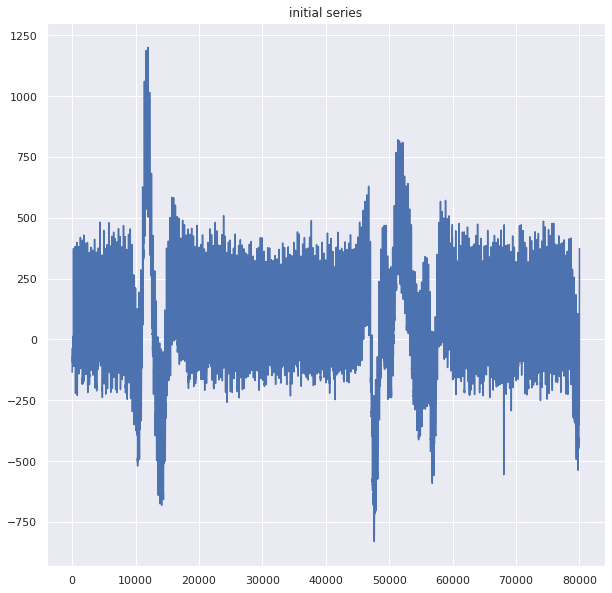

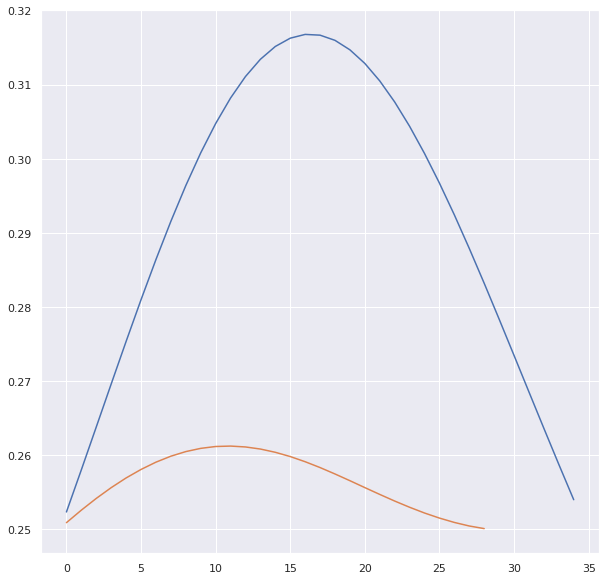

Period autocorrelation 33115
ext= .txt
split index 20000
time series:         Data
0 -0.556660
1 -0.475257
2 -0.513627
3 -0.477920
4 -0.467450
split index 20000
train time seried data frame 0   -0.556660
1   -0.475257
2   -0.513627
3   -0.477920
4   -0.467450
Name: Data, dtype: float64
train time seried data frame 0       -0.556660
1       -0.475257
2       -0.513627
3       -0.477920
4       -0.467450
           ...   
19995   -0.177090
19996   -0.301934
19997   -0.382327
19998   -0.446036
19999   -0.441419
Name: Data, Length: 20000, dtype: float64
train time_series_df shape =  (20000,)
test time seried data frame 20000   -0.444579
20001   -0.467706
20002   -0.467457
20003   -0.447662
20004   -0.473142
Name: Data, dtype: float64
test time seried data frame 20000   -0.444579
20001   -0.467706
20002   -0.467457
20003   -0.447662
20004   -0.473142
           ...   
79994    1.245398
79995    1.411549
79996    1.607899
79997    1.772047
79998    1.957441
Name: Data, Length: 59999, dtype: 

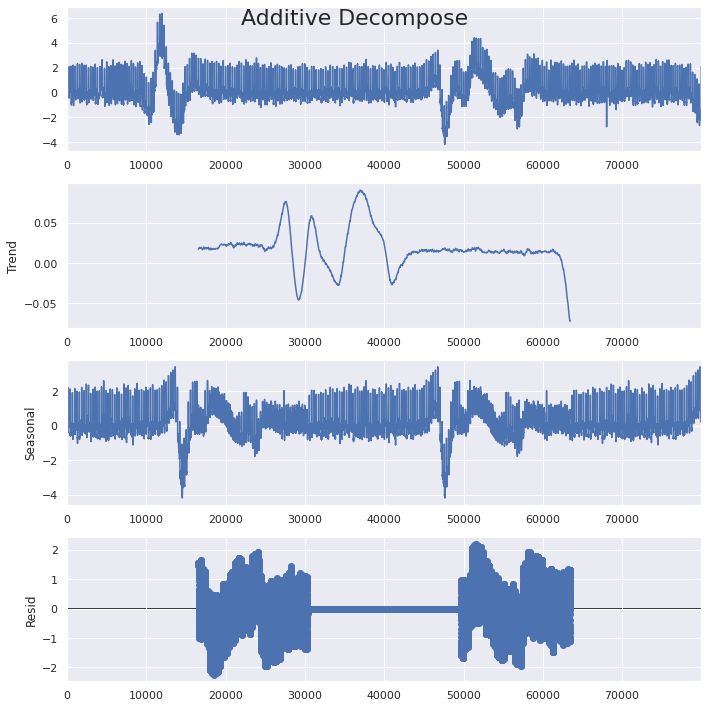

KeyboardInterrupt: ignored

In [ ]:
#from pandas import DataFrame

#print all data files 
print("Files with data", data_files) 


#get the id of files from its names 
file_ids=[]
for i in range(0,len(data_files)):
    split_=data_files[i].split('_')[0]
    file_ids.append(int(split_[0:3]))

print('file ids',file_ids)

#get meta data for phase1 files (there are metadata on all files in metadata.csv)
meta_data_ph1 = meta_data_df[ meta_data_df['data_id'].isin(file_ids) ]

print('metadata of files from phase 1',meta_data_ph1)


#number of the file 
file_num = 19
#id of the file 
file_id = file_ids[file_num]
#file name 
file_name=data_files[file_num]

print('file index',file_num)
print('file id',file_id)
print('file name',file_name)

#metadata of the file 
metadata_of_file_num=meta_data_df[ meta_data_df['data_id'] == file_id ]
print('metadata of the file',metadata_of_file_num)

#real start of anomaly 
anomaly_start_real=metadata_of_file_num['anomaly_start'].values
print('anomaly_start_real',anomaly_start_real)
print(np.shape(anomaly_start_real))
print(np.size(anomaly_start_real))

#real end of anomaly 
anomaly_end_real=metadata_of_file_num['anomaly_end'].values
print('anomaly_end_real',anomaly_end_real)
print(np.shape(anomaly_end_real))
print(np.size(anomaly_end_real))


#evaluate 
#print('file',file_name,'start',anomaly_start_real,'end',anomaly_end_real)

eval_res=evaluation_time_series(file_name,anomaly_start_real,anomaly_end_real)

print('evaluation ',eval_res)
